In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

In [3]:
train_sero = pd.read_csv("./train_sero.csv")
company_start_year = pd.read_csv("./company_start_year.csv")
y = pd.read_csv("./y.csv")
X = pd.read_csv("./2year.csv")

In [38]:
sero_data = pd.read_csv("./data/sero_data.csv")

In [6]:
data = pd.read_csv("All.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 전처리

In [94]:
def rnn_data_preprocessing(X, y):
    x = X[:]
    # feature로 사용하지 않을 feature 제거
    for i in x.columns:
        if ("year" == i.split("_")[0]) or ("Id" == i.split("_")[0]):
            x.drop([i], axis=1, inplace=True)
            
    # 범주형 변수 -> one-hot encoding
    # ao, ms, cs
    label_columns = ["AO","MS","CS"]
    del_columns = []
    x_First = True
    y_First = True
    for i in label_columns:
        for j in x.columns:
            if i == j.split("_")[0]:
                del_columns.append(j)
                if x_First:
                    a = pd.get_dummies(x[j])
                    x_First = False
                elif y_First:
                    b = pd.get_dummies(x[j])
                    y_First = False
                elif "x" == j.split("_")[1]:
                    a = pd.concat([a,pd.get_dummies(x[j])], axis=1)
                elif "y" == j.split("_")[1]:
                    b = pd.concat([b,pd.get_dummies(x[j])], axis=1)
    x = pd.concat([a,x], axis=1)
    x = pd.concat([x,b], axis=1)
    print(del_columns)
    x.drop(del_columns, axis=1, inplace=True) 
    
    
    # 전년도 신용도와 현년도 신용도를 합침
    y = y.reset_index()
    y = pd.concat([x["CR_y"],y["CR"]], axis=1)
    
    # 부도와 부도가 아닌 것으로 분류
    y[y!=0]=1

    return x, y

In [96]:
X_data, y_data = rnn_data_preprocessing(X,y[2191*2:])

['AO_x', 'AO_y', 'MS_x', 'MS_y', 'CS_x', 'CS_y']


In [97]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data,y_data,
                                                   random_state = 1)

### 표준화

In [98]:
# normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [99]:
# 표준화
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [101]:
# RNN 데이터 차원에 맞도록 조정
X_train = X_train.reshape(X_train.shape[0],2,X_train.shape[1]//2)
X_valid = X_valid.reshape(X_valid.shape[0],2,X_valid.shape[1]//2)

## 모델 생성

- class weight -> 0:0.2, 1:0.8 로 해줌으로써 불균형 데이터 해소

In [191]:
import os
root_logdir = os.path.join(os.curdir, "tensorboard")

# 루트 로그 디렉터리와 현재 날짜와 시간을 이용한 서브 디렉터리 생성하는 함수
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id) # 디렉토리 주소를 반환

run_logdir = get_run_logdir() # 새로 그래프를 생성하려고 할 때마다 이 것을 실행해 주어야 함 

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint("rnn_best_model.h5",
                                               save_best_only = True)

In [192]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(256, activation = "tanh",return_sequences = True, input_shape =[None,43]),
    keras.layers.SimpleRNN(256, activation = "tanh",return_sequences = True),
    keras.layers.Dense(1, activation = "sigmoid")
])

In [193]:
model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Adam(lr=1e-5),
             metrics = "accuracy")

In [194]:
X_train = X_train.reshape(X_train.shape[0],2,43)
X_valid = X_valid.reshape(X_valid.shape[0],2,43)

In [195]:
history = model.fit(x=X_train,y=y_train.astype("int"), epochs = 50, 
                    validation_data = (X_valid,y_valid.astype("int")), class_weight = {0:0.8, 1:0.2},
                   callbacks = [tensorboard_cb, checkpoint_cb])

Epoch 1/50
873/873 [==============================] - 10s 11ms/step - loss: 0.1839 - accuracy: 0.8824 - val_loss: 0.1709 - val_accuracy: 0.9161
Epoch 2/50
873/873 [==============================] - 5s 6ms/step - loss: 0.0808 - accuracy: 0.9562 - val_loss: 0.1202 - val_accuracy: 0.9635
Epoch 3/50
873/873 [==============================] - 5s 5ms/step - loss: 0.0554 - accuracy: 0.9657 - val_loss: 0.1091 - val_accuracy: 0.9669
Epoch 4/50
873/873 [==============================] - 5s 6ms/step - loss: 0.0457 - accuracy: 0.9700 - val_loss: 0.1052 - val_accuracy: 0.9702
Epoch 5/50
873/873 [==============================] - 5s 5ms/step - loss: 0.0405 - accuracy: 0.9720 - val_loss: 0.1032 - val_accuracy: 0.9714
Epoch 6/50
873/873 [==============================] - 5s 6ms/step - loss: 0.0372 - accuracy: 0.9734 - val_loss: 0.1012 - val_accuracy: 0.9730
Epoch 7/50
873/873 [==============================] - 5s 5ms/step - loss: 0.0350 - accuracy: 0.9741 - val_loss: 0.1011 - val_accuracy: 0.9741
Epoc

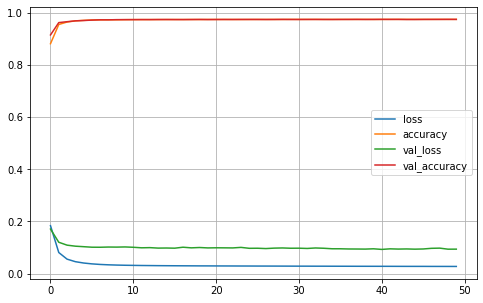

In [196]:
# 에포크가 끝날 때 마다의 train, valid set의 loss, 평가 지표
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True) # grid를 생성
#plt.gca().set_ylim(0,1) # 수직출의 범위를 0~1 사이로 설정
plt.show()

## 모델 평가

In [185]:
model = keras.models.load_model("rnn_best_model.h5")

In [186]:
model.evaluate(X_valid,y_valid)

291/291 [==============================] - 1s 2ms/step - loss: 0.0868 - accuracy: 0.9766


[0.08682124316692352, 0.9765893220901489]

In [187]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

In [188]:
predicted = model.predict_classes(X_valid)[:,1].flatten()
target = y_valid["CR"]
print(f"accuracy score : {accuracy_score(target, predicted)}")
print(f"precision score : {precision_score(target,predicted)}")
print(f"recall_score : {recall_score(target, predicted)}")
print(f"confusion matrix : \n {confusion_matrix(target, predicted)}")
print(f"roc-auc score : {roc_auc_score(target, predicted)}")

accuracy score : 0.9764819587628866
precision score : 0.9966887417218543
recall_score : 0.9759321611173463
confusion matrix : 
 [[1267   26]
 [ 193 7826]]
roc-auc score : 0.9779119428943267
